In [1]:
import numpy as np
import pandas as pd


In [2]:
sns.set_context("talk")

In [3]:

def slice_1d_with_v(x, y, v, x_wind, step = 1):
    """ Slices one set of data from 1 well. Including velocity.

    x: x-data array (seism data).
    y: y-data array (GIS data).
    v: velocity value.
    x_wind: size of x-window to slice.
    step: step of slicing.
    """
    x_hlf_wind = x_wind//2
    x = np.array(x)
    y = np.array(y)
    x_sl, y_sl = [], []

    for i in range(x_hlf_wind, len(y)-x_hlf_wind, step):
        x_sl.append(np.concatenate([x[i-x_hlf_wind:i+x_hlf_wind+1], np.array([v])]))
        y_sl.append(y[i])

    return np.array(x_sl), np.array(y_sl)


def slice_2d_with_v(m_x, m_y, ar_v, x_wind, step = 1):
    """ Slices matrexes set of data from several wells. 
    Including velocity in x data.

    m_x: list of x-data arrays (seism data) from several wells.
    y: list of y-data arrays (GIS data) from several wells.
    ar_v: list of velocities in several wells.
    x_wind: size of x-window to slice.
    step: step of slicing.
    """
    ar_x, ar_y = slice_1d_with_v(m_x[0], m_y[0], ar_v[0], x_wind, step = 1)
    m_x_sl, m_y_sl = np.array(ar_x), np.array(ar_y)


    for j in range(1, len(m_y)):
        ar_x, ar_y = slice_1d_with_v(m_x[j], m_y[j], ar_v[j], x_wind)
        #print(f"ar_x: {ar_x}")
        #print(f"ar_y: {ar_y}")
        if len(ar_x)*len(ar_y)!=0:
            m_x_sl = np.concatenate([m_x_sl, ar_x], axis = 0)
            m_y_sl = np.concatenate([m_y_sl, ar_y], axis = 0)


    return m_x_sl, m_y_sl

## Теперь на реальных данных:

In [4]:
PATH_TO_SEISM = "Reindex_seism.csv"
PATH_TO_GIS = "Reindex_GIS.xlsx"
PATH_INFO = "Wells_info.csv"
GIS_TRASH_HOLD = 1
X_WIND = 5

df_seisma = pd.read_csv(PATH_TO_SEISM, sep=";")
df_seisma.set_index("Unnamed: 0", inplace=True)
df_seisma.index.name = "z"

df_gis = pd.read_excel(PATH_TO_GIS)
df_gis.set_index("Depth", inplace=True)
df_gis.index.name = "z"

In [5]:
df_info = pd.read_csv(PATH_INFO, sep=";")

Отложение первых 4-х скважин

In [8]:
test_wells = ["g274", "g276", "g277", "g278"]

In [9]:
df_seisma_test, df_gis_test = df_seisma[test_wells], df_gis[test_wells]

In [10]:
df_seisma, df_gis = df_seisma.drop(test_wells, axis = 1), df_gis.drop(test_wells, axis = 1)

Поиск пересечения вышек

In [11]:
all_columns = sorted(list(set(df_seisma.columns) & set(df_gis.columns)))
df_seisma, df_gis = df_seisma[all_columns], df_gis[all_columns]

Подготовка для нарезки

In [12]:
df_info.set_index("Well", inplace=True)

In [13]:
x_to_slice = []
y_to_slice = []
ar_mask = []
ar_mask_x = []
ar_v = []

for well_name in df_seisma.columns:
    x = df_seisma[well_name]
    y = df_gis[well_name]

    mask_x_0 = (x!=0.0)
    x_accurance = np.where(x!=0.0)[0]
    x_start_p = max(x_accurance[0], 0)
    x_end_p = min(x_accurance[-1], x.shape[0])
    mask_x = np.array([True if (i>=x_start_p and i<=x_end_p) else False for i in range(mask_x_0.shape[0])])

    mask_y_0 = (y>GIS_TRASH_HOLD)
    y_accurance = np.where(y>=GIS_TRASH_HOLD)[0]
    # X_WIND//2 adding for getting bound data while slicing data down bellow the code
    y_start_p = max(y_accurance[0] - X_WIND//2, 0)
    y_end_p = min(y_accurance[-1] + X_WIND//2, y.shape[0])
    mask_y = np.array([True if (i>=y_start_p and i<=y_end_p) else False for i in range(mask_x_0.shape[0])])

    mask = mask_x*mask_y

    x_to_slice.append(x[mask].to_list())
    y_to_slice.append(y[mask].to_list())
    ar_mask.append(mask)
    ar_mask_x.append(mask_x)
    ar_v.append(df_info.loc[well_name]["v"])


ar_mask = np.array(ar_mask)
ar_mask_x = np.array(ar_mask_x)
ar_v = np.array(ar_v)

Нарезка данных

In [14]:
x, y = slice_2d_with_v(x_to_slice, y_to_slice, ar_v, x_wind=X_WIND)
x, y

(array([[ 4.63186220e-01, -5.99848862e-01,  8.43199202e-01,
         -6.53726225e-01,  1.88192379e-03,  1.10831234e+03],
        [-5.99848862e-01,  8.43199202e-01, -6.53726225e-01,
          1.88192379e-03, -8.27930396e-01,  1.10831234e+03],
        [ 8.43199202e-01, -6.53726225e-01,  1.88192379e-03,
         -8.27930396e-01, -7.85848940e-01,  1.10831234e+03],
        ...,
        [ 6.56624278e+00, -4.68030329e+00, -2.03738928e+00,
         -2.04374889e+00,  1.06107863e+00,  1.22765842e+03],
        [-4.68030329e+00, -2.03738928e+00, -2.04374889e+00,
          1.06107863e+00,  7.73765534e-01,  1.22765842e+03],
        [-2.03738928e+00, -2.04374889e+00,  1.06107863e+00,
          7.73765534e-01,  3.87321505e-01,  1.22765842e+03]]),
 array([10.58108072, 10.05650983, 10.14658394, ...,  7.63727129,
         5.5833931 ,  1.773448  ]))

In [15]:
x.shape, y.shape

((5363, 6), (5363,))

# **1 модель - нейронка с настриваемыми параметрами**

In [16]:
import numpy as np
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

# **Нормализация**

***Z-score normalization, or standardization***

centers the data with a mean of 0 and a standard deviation of 1

In [17]:
scaler_z = StandardScaler()

In [18]:
x_scaled_z = scaler_z.fit_transform(x)

***Min-Max Normalization ***

0 to 1


In [19]:
y_reshaped = np.array(y).reshape(-1,1)
y_reshaped.shape

(5363, 1)

In [20]:
scaler_m = MinMaxScaler()

In [21]:
y_scaled_m = scaler_m.fit_transform(y_reshaped)

In [22]:
#x.mean(), x_scaled_z.mean(), y.mean(), y_scaled_m.mean()

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled_z, y_scaled_m, test_size=0.1,
                                                    random_state = 42)

# **Моделька**

In [24]:
model_mlp = MLPRegressor(hidden_layer_sizes=(5), random_state=42, activation='tanh', solver='adam',
                    early_stopping=True, validation_fraction=2/7, n_iter_no_change=100,
                    max_iter=1000, warm_start = False)

In [25]:
model_mlp.fit(x_train, y_train)

c:\Users\Gavriil\VS_projects\Interpolation-of-logging-curves\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1624: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='tanh', early_stopping=True, hidden_layer_sizes=5,
             max_iter=1000, n_iter_no_change=100, random_state=42,
             validation_fraction=0.2857142857142857)

Среднеквадратичная ошибка: 0.010836000432125945
R2: 0.16739773427424298


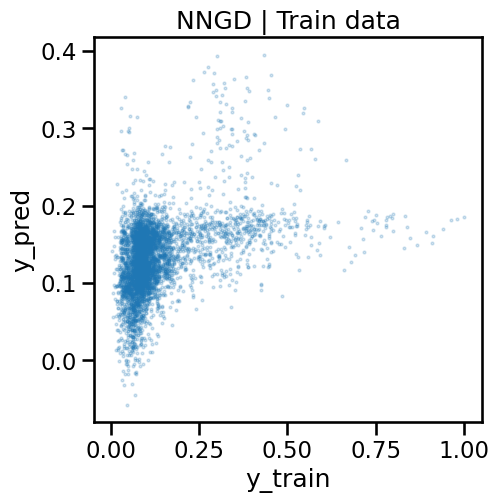

In [26]:
#Прогнозирование на Тренировочных данных
y_pred = model_mlp.predict(x_train)


# Оценка качества модели (среднеквадратичная ошибка)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"Среднеквадратичная ошибка: {mse}")
print(f"R2: {r2}")
fig, ax = plt.subplots(figsize=(5,5))

plt.plot(y_train, y_pred, 'o', markersize=2, alpha = 0.2)
ax.set_title("NNGD | Train data")
ax.set_xlabel("y_train")
ax.set_ylabel("y_pred")

plt.show()

Среднеквадратичная ошибка: 0.008672154212616565
R2: 0.14084104342516468


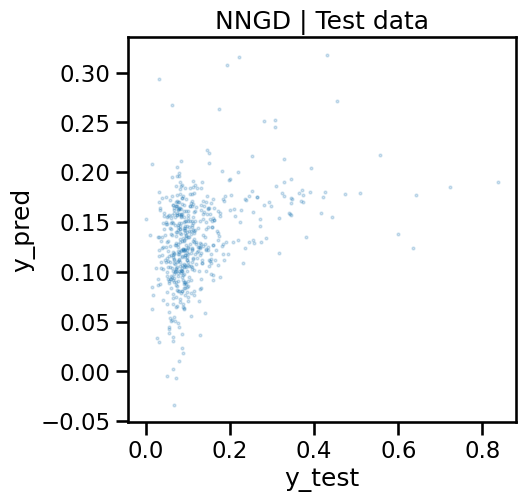

In [27]:
# Прогнозирование на Тестовых данных
y_pred = model_mlp.predict(x_test)


# Оценка качества модели (среднеквадратичная ошибка)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Среднеквадратичная ошибка: {mse}")
print(f"R2: {r2}")

fig, ax = plt.subplots(figsize=(5,5))

plt.plot(y_test, y_pred, 'o', markersize=2, alpha = 0.2)
ax.set_title("NNGD | Test data")
ax.set_xlabel("y_test")
ax.set_ylabel("y_pred")

plt.show()

# **RandomForest**

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1,  random_state = 42)

In [29]:
model_forest = RandomForestRegressor(n_estimators=100, random_state=42,  n_jobs=-1)

In [30]:
model_forest.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

Среднеквадратичная ошибка: 9.944786117676397
R2: 0.9226082332272383


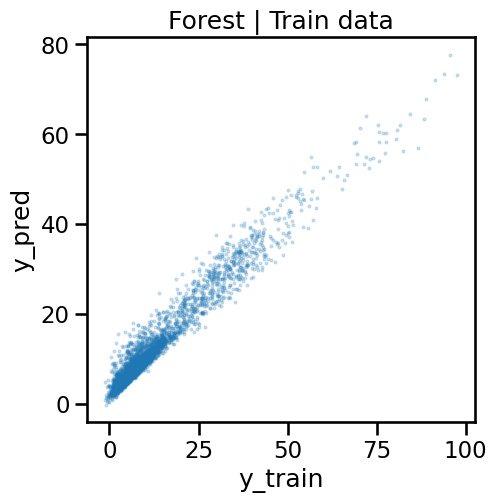

In [31]:
#Прогнозирование на Тренировочных данных
y_pred = model_forest.predict(x_train)


# Оценка качества модели (среднеквадратичная ошибка)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"Среднеквадратичная ошибка: {mse}")
print(f"R2: {r2}")
fig, ax = plt.subplots(figsize=(5,5))

plt.plot(y_train, y_pred, 'o', markersize=2, alpha = 0.2)
ax.set_title("Forest | Train data")
ax.set_xlabel("y_train")
ax.set_ylabel("y_pred")

plt.show()

Среднеквадратичная ошибка: 50.467012545278656
R2: 0.4936102970294486


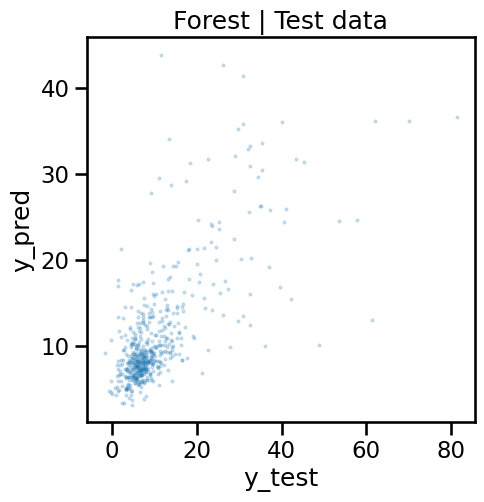

In [32]:
# Прогнозирование на Тестовых данных
y_pred = model_forest.predict(x_test)


# Оценка качества модели (среднеквадратичная ошибка)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Среднеквадратичная ошибка: {mse}")
print(f"R2: {r2}")

fig, ax = plt.subplots(figsize=(5,5))

plt.plot(y_test, y_pred, 'o', markersize=2, alpha = 0.2)
ax.set_title("Forest | Test data")
ax.set_xlabel("y_test")
ax.set_ylabel("y_pred")

plt.show()

# XGBoost

Более регуляризованная форма градиентного бустинга (вариация для задач регрессии)

In [33]:
model_xgb = XGBRegressor(objective='reg:squarederror') #https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

In [34]:
model_xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Среднеквадратичная ошибка: 6.636720310911405
R2: 0.9483520807425755


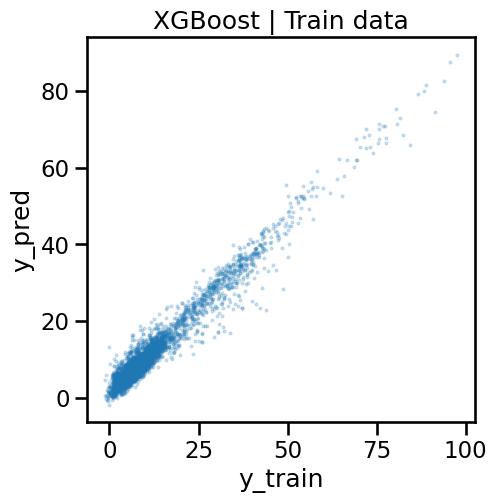

In [35]:
#Прогнозирование на Тренировочных данных
y_pred = model_xgb.predict(x_train)


# Оценка качества модели (среднеквадратичная ошибка)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"Среднеквадратичная ошибка: {mse}")
print(f"R2: {r2}")
fig, ax = plt.subplots(figsize=(5,5))

plt.plot(y_train, y_pred, 'o', markersize=2, alpha = 0.2)
ax.set_title("XGBoost | Train data")
ax.set_xlabel("y_train")
ax.set_ylabel("y_pred")

plt.show()

Среднеквадратичная ошибка: 55.7959174019908
R2: 0.44013967510333973


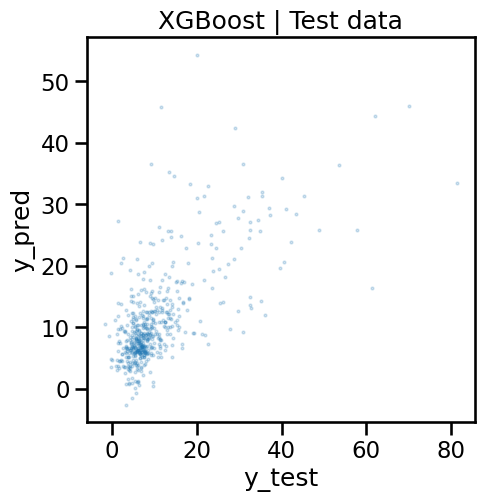

In [36]:
# Прогнозирование на Тестовых данных
y_pred = model_xgb.predict(x_test)


# Оценка качества модели (среднеквадратичная ошибка)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Среднеквадратичная ошибка: {mse}")
print(f"R2: {r2}")

fig, ax = plt.subplots(figsize=(5,5))

plt.plot(y_test, y_pred, 'o', markersize=2, alpha = 0.2)
ax.set_title("XGBoost | Test data")
ax.set_xlabel("y_test")
ax.set_ylabel("y_pred")

plt.show()

## Визуализация предсказания

In [91]:
test_wells

['g274', 'g276', 'g277', 'g278']

In [92]:
g_name = "g278"

In [93]:
x_to_slice_g = []
y_to_slice_g = []
ar_mask = []
ar_mask_x = []

for well_name in [g_name]:
    x = df_seisma_test[well_name]
    y = df_gis_test[well_name]

    mask_x_0 = (x!=0.0)
    x_accurance = np.where(x!=0.0)[0]
    x_start_p = max(x_accurance[0], 0)
    x_end_p = min(x_accurance[-1], x.shape[0])
    mask_x = np.array([True if (i>=x_start_p and i<=x_end_p) else False for i in range(mask_x_0.shape[0])])

    mask_y_0 = (y>GIS_TRASH_HOLD)
    y_accurance = np.where(y>=GIS_TRASH_HOLD)[0]
    # X_WIND//2 adding for getting bound data while slicing data down bellow the code
    y_start_p = max(y_accurance[0] - X_WIND//2, 0)
    y_end_p = min(y_accurance[-1] + X_WIND//2, y.shape[0])
    mask_y = np.array([True if (i>=y_start_p and i<=y_end_p) else False for i in range(mask_x_0.shape[0])])

    mask = mask_x*mask_y

    x_to_slice_g.append(x[mask].to_list())
    y_to_slice_g.append(y[mask].to_list())
    ar_mask.append(mask)
    ar_mask_x.append(mask_x)


ar_mask_g = np.array(ar_mask)
ar_mask_x_g = np.array(ar_mask_x)

In [94]:
x_g, y_g = slice_2d_with_v(x_to_slice_g, y_to_slice_g, ar_v, x_wind=X_WIND)
#x_g277, y_g277

In [95]:
model = model_forest

y_pred_g = model.predict(x_g)

In [96]:
y_g, y_pred_g

(array([ 3.27260201,  8.77286652, 12.18463433, 17.09545622, 28.17406553,
        41.04230548, 45.61602182, 37.90058772, 23.59489405, 11.39203391,
         5.50196224,  4.16967947,  3.83250007,  3.3115501 ,  3.30005347,
         4.00011108,  5.21085214,  6.63495577,  7.15995864,  6.24642307,
         5.8284871 ,  7.39201356,  8.48890125,  6.1030447 ,  1.72772158]),
 array([11.09025372, 11.24383609, 19.99378675, 21.01123159, 18.12815816,
        25.54785884, 19.89643805, 22.2949132 , 19.75803331, 13.40767223,
        13.07954644,  6.55175098,  8.49281548,  8.19405282,  7.42426676,
         5.91193418,  5.55229178,  8.54252978,  6.46659732,  6.86870226,
        11.65572366,  7.61573785, 15.58999362, 26.14929188,  4.66592809]))

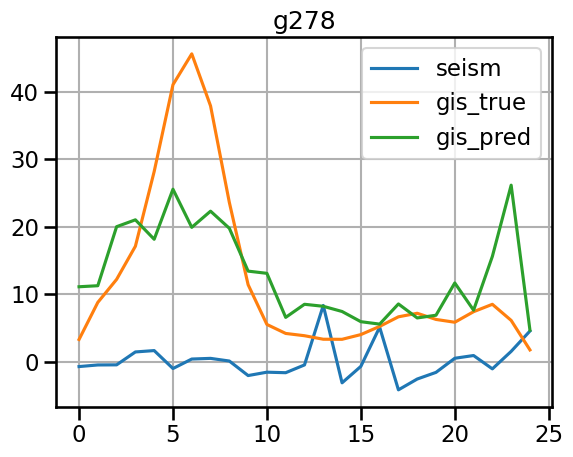

In [97]:
plt.plot(list(range(len(y_g))), x_to_slice_g[0][X_WIND//2:-X_WIND//2+1], label='seism') 
plt.plot(list(range(len(y_g))), y_g, label='gis_true')
plt.plot(list(range(len(y_g))), y_pred_g, label='gis_pred')
plt.title(g_name)
plt.grid()
plt.legend()